## 超分辨率 Learning Project

[参考1: Super_Resolution](https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/07_Super_Resolution.ipynb)\
[参考2: superres-gan](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres-gan.ipynb)

https://zhuanlan.zhihu.com/p/87253140

概要:

* Image -> Image 数据加载方式
* Unet 来实现超分

## Init fast ai

In [1]:
#hide
!pip install -Uq fastai
import fastai
from fastai.vision.all import *
from fastai.vision import *
from fastai.callback import *
from fastai.vision.gan import *
import shutil

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

crappify data

In [3]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
        
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [4]:
import glob
imgs = [Path(i) for i in glob.glob(str(path_hr)+'/*.jpg')]
parallel(crappifier(path_lr, path_hr), imgs)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

<AxesSubplot:>

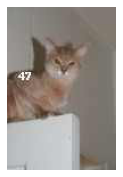

In [5]:
bad_imgs = get_image_files(path_lr)
im1 = PILImage.create(bad_imgs[0])
im1.show()

## Superres Using Unet

In [5]:
def get_dls(bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                    get_items=get_image_files,
                    get_y=lambda x: path_hr/x.name,
                    splitter=RandomSplitter(),
                    item_tfms=Resize(size),
                    batch_tfms=[*aug_transforms(max_zoom=2.),
                                Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3
  return dls

In [6]:
dls_gen = get_dls(32, 128)

### 数据可视化

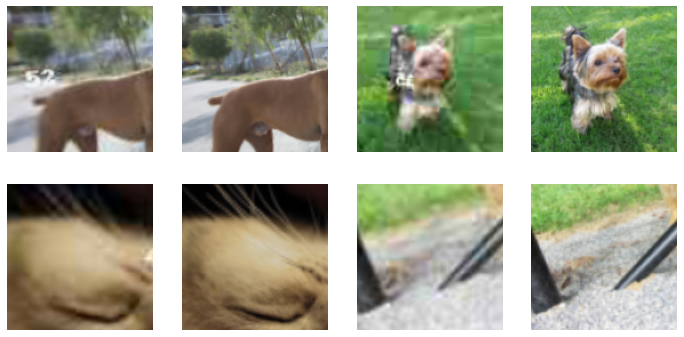

In [7]:
dls_gen.show_batch(max_n=4)

数据信息:

In [8]:
# size of batch, batch size, dataset size
len(dls_gen.train), dls_gen.bs, len(dls_gen.dataset.items)

(184, 32, 5912)

In [9]:
# input, output image size
ob = dls_gen.one_batch()
ob[0].shape, ob[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 3, 128, 128]))

### Learner

#### create learner

一些参数的解释:
* `wd`\
  wd is the default weight decay used when training the model.
* `norm_type` \
  [Batch Normalization Type](https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6)

* `blur`\
  [Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts](https://arxiv.org/abs/1806.02658)  where the authors add a little bit of blur to completely get rid of checkerboard artifacts.

* `self_attension`\
  Self-attention layer as introduced in [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318)

* `y_range`\
  y_range is passed, the function adds a SigmoidRange to that range

In [7]:
wd, y_range, loss_gen, bbone = 1e-3, (-3., 3.), MSELossFlat(), resnet34

In [8]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, wd=wd, loss_func=loss_gen, 
                      blur=True, norm_type=NormType.Weight,
                      self_attention=True, y_range=y_range)

In [9]:
learn_gen = create_gen_learner()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

#### training

In [19]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.073838,0.058340,01:34
1,0.039926,0.039214,01:29


In [20]:
learn_gen.unfreeze()

In [21]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.038072,0.038018,01:34
1,0.035279,0.035033,01:31
2,0.033671,0.034119,01:34


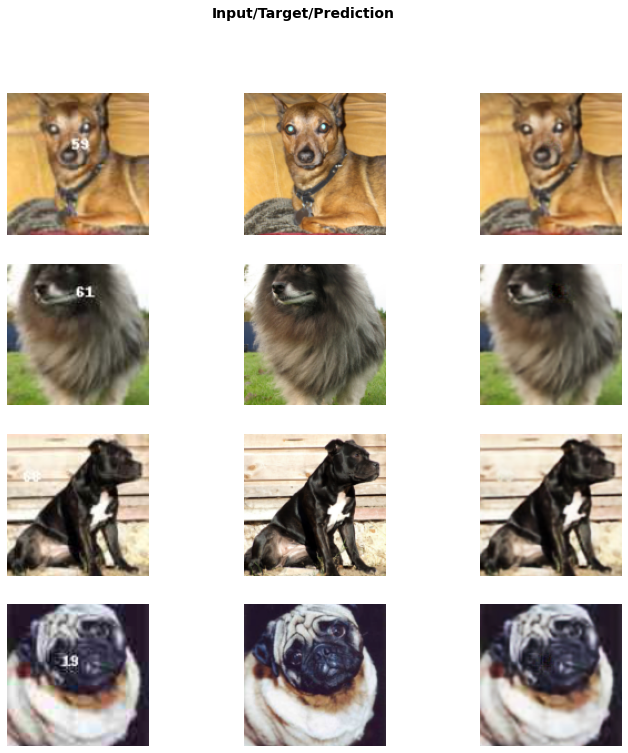

In [22]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [23]:
learn_gen.save('gen-pre2')

Path('/root/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth')

In [29]:
import shutil
shutil.copy('/root/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth', '/content/gdrive/MyDrive/fast_ai/gen-pre2.pth')

'/content/gdrive/MyDrive/fast_ai/gen-pre2.pth'

### Save the generated image

load pre trained model:

In [10]:
path_model = path/'models'
path_model.mkdir(exist_ok=True)

In [11]:
shutil.copy('/content/gdrive/MyDrive/fast_ai/gen-pre2.pth', '/root/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth')

'/root/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth'

In [12]:
learn_gen.load('gen-pre2')

解除数据增强, 使用原始数据:\
dl.after_batch是后处理操作pipeline

In [13]:
dl = dls_gen.train.new(
    shuffle=False, drop_last=False, 
    after_batch=[IntToFloatTensor,Normalize.from_stats(*imagenet_stats)])

#### look at the result:

In [21]:
preds, _ = learn_gen.get_preds(dl=dl)
preds.shape

KeyboardInterrupt: ignored

In [ ]:
# get prediction
pred_0 = preds[0].permute(1,2,0).numpy()
plt.imshow(pred_0)

In [ ]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]
output=dec.numpy().transpose(1,2,0)
plt.imshow(output)

#### save result

In [14]:
path_gen = path/'image_gen'
path_gen.mkdir(exist_ok=True)

In [15]:
def save_preds(dl, learn):
  names = dl.dataset.items
  preds, _ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
    dec = dl.after_batch.decode((TensorImage(pred[None]), ))[0][0]
    arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
    Image.fromarray(arr).save(path_gen/names[i].name)

In [16]:
save_preds(dl, learn_gen)

save to google drive

In [17]:
shutil.copytree(path_gen, '/content/gdrive/MyDrive/fast_ai/image_gen')

'/content/gdrive/MyDrive/fast_ai/path_gen'

## Superres Using GAN

restore from google drive

In [ ]:
path_gen = path/'image_gen'
path_gen.mkdir(exist_ok=True)

from google.colab import drive
drive.mount('/content/gdrive')
shutil.copytree('', path_gen)

### Train Criti(判别器)

In [18]:
path_g = get_image_files(path/'image_gen')
path_i = get_image_files(path/'images')

In [19]:
path_g, path_i

((#5912) [Path('/root/.fastai/data/oxford-iiit-pet/image_gen/Abyssinian_129.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/pomeranian_4.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/havanese_189.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/great_pyrenees_70.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/miniature_pinscher_172.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/wheaten_terrier_47.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/Persian_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/leonberger_58.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/Abyssinian_185.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/image_gen/japanese_chin_69.jpg')...],
 (#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_129.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_4.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_165.jpg'),Path('/root/.fastai/data/oxford-iiit-pe

In [30]:
def get_crit_dls(bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items = get_image_files,
                     splitter=RandomSplitter(),
                     item_tfms=Resize(size),
                     get_y = parent_label)
  return dblock.dataloaders(path, bs=bs, path=path)

In [33]:
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [34]:
!ls /root/.fastai/data/oxford-iiit-pet

annotations  crappy  image_gen	images	models


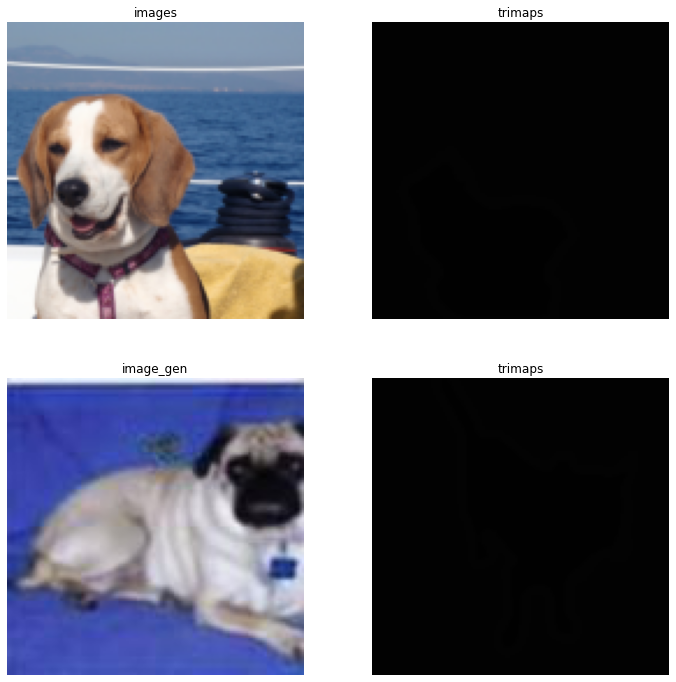

In [31]:
dls_crit = get_crit_dls(32, 128)
dls_crit.show_batch(max_n=4, figsize=(12,12))